# Cross boundary correctness score

Analysis of cross boundary correctness (CBC) score of pseudotime-based analysis with the PseudotimeKernel and an RNA velocity-based analysis with VelocityKernel on the NeurIPS 2021 hematopoiesis data.

## Library imports

In [1]:
import os
import sys

from tqdm import tqdm

import numpy as np
import pandas as pd
from scipy.stats import ttest_ind

import matplotlib.pyplot as plt
import mplscience
import seaborn as sns
from matplotlib.patches import Patch

import cellrank as cr
import scanpy as sc
import scvelo as scv
from anndata import AnnData

from cr2 import running_in_notebook

sys.path.extend(["../../../", "."])
from paths import DATA_DIR, FIG_DIR  # isort: skip  # noqa: E402

Global seed set to 0


## General settings

In [2]:
sc.settings.verbosity = 2
cr.settings.verbosity = 4
scv.settings.verbosity = 3

In [3]:
scv.settings.set_figure_params("scvelo", dpi_save=400, dpi=80, transparent=True, fontsize=20, color_map="viridis")

In [4]:
SAVE_FIGURES = False
if SAVE_FIGURES:
    os.makedirs(FIG_DIR / "pseudotime_kernel" / "hematopoiesis", exist_ok=True)

FIGURE_FORMAT = "pdf"

In [5]:
os.makedirs(DATA_DIR / "hematopoiesis" / "results", exist_ok=True)

## Constants

In [6]:
N_JOBS = 8

In [7]:
CELLTYPES_TO_KEEP = [
    "HSC",
    "MK/E prog",
    "Proerythroblast",
    "Erythroblast",
    "Normoblast",
    "cDC2",
    "pDC",
    "G/M prog",
    "CD14+ Mono",
]

In [8]:
STATE_TRANSITIONS = [
    ("HSC", "pDC"),
    ("HSC", "cDC2"),
    ("HSC", "G/M prog"),
    ("G/M prog", "CD14+ Mono"),
    ("HSC", "MK/E prog"),
    ("MK/E prog", "Proerythroblast"),
    ("Proerythroblast", "Erythroblast"),
    ("Erythroblast", "Normoblast"),
]

## Function definitions

In [9]:
def get_significance(pvalue) -> str:
    """Assign significance symbol based on p-value."""
    if pvalue < 0.001:
        return "***"
    elif pvalue < 0.01:
        return "**"
    elif pvalue < 0.1:
        return "*"
    else:
        return "n.s."

In [10]:
def get_dpt_adata() -> AnnData:
    """Load and preprocess data for pseudotime-based analysis."""
    adata = sc.read(DATA_DIR / "hematopoiesis" / "processed" / "gex_preprocessed.h5ad")
    adata = adata[adata.obs["l2_cell_type"].isin(CELLTYPES_TO_KEEP), :].copy()

    sc.pp.neighbors(adata, use_rep="MultiVI_latent")
    sc.tl.umap(adata)

    sc.tl.diffmap(adata, n_comps=15)

    df = (
        pd.DataFrame(
            {
                "diff_comp": adata.obsm["X_diffmap"][:, 5],
                "cell_type": adata.obs["l2_cell_type"].values,
            }
        )
        .reset_index()
        .rename({"index": "obs_id"}, axis=1)
    )
    df = df.loc[df["cell_type"] == "HSC", "diff_comp"]
    root_idx = df.index[df.argmax()]

    adata.uns["iroot"] = root_idx
    sc.tl.dpt(adata, n_dcs=6)

    return adata

In [11]:
def get_velo_adata() -> AnnData:
    """Load and preprocess data for RNA velocity-based analysis."""
    adata = sc.read(DATA_DIR / "hematopoiesis" / "processed" / "gex_velocity.h5ad")
    adata = adata[adata.obs["l2_cell_type"].isin(CELLTYPES_TO_KEEP), :].copy()

    scv.pp.filter_genes(adata, min_shared_counts=20)
    scv.pp.normalize_per_cell(adata)

    sc.pp.neighbors(adata, use_rep="MultiVI_latent")
    sc.tl.umap(adata)

    scv.pp.moments(adata, n_pcs=None, n_neighbors=None)

    scv.tl.recover_dynamics(adata, n_jobs=N_JOBS)
    scv.tl.velocity(adata, mode="dynamical")

    return adata

## Data loading

In [12]:
adatas = {}

adatas["dpt"] = get_dpt_adata()
adatas["dpt"].obs["obs_id"] = np.arange(0, adatas["dpt"].n_obs)
adatas["dpt"]

computing neighbors
    finished (0:02:26)
computing UMAP
    finished (0:00:10)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.99922997 0.9977195  0.9968419  0.9955766  0.9942717
     0.9900949  0.9884704  0.9867782  0.9852537  0.9849594  0.9830871
     0.98229724 0.9809607  0.97756666]
    finished (0:00:00)
computing Diffusion Pseudotime using n_dcs=6
    finished (0:00:00)


AnnData object with n_obs × n_vars = 24440 × 25629
    obs: 'site', 'donor', 'batch', 'l1_cell_type', 'l2_cell_type', 'dpt_pseudotime', 'obs_id'
    var: 'hvg_multiVI'
    uns: 'neighbors', 'umap', 'diffmap_evals', 'iroot'
    obsm: 'MultiVI_latent', 'X_umap', 'X_diffmap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [13]:
adatas["rna_velocity"] = get_velo_adata()
adatas["rna_velocity"]

Filtered out 16169 genes that are detected 20 counts (shared).
Normalized count data: spliced, unspliced.
computing neighbors
    finished (0:00:02)
computing UMAP
    finished (0:00:10)
computing moments based on connectivities
    finished (0:00:09) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 8/14 cores)


  0%|          | 0/1504 [00:00<?, ?gene/s]

Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0


    finished (0:03:29) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:19) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


AnnData object with n_obs × n_vars = 24440 × 9460
    obs: 'batch', 'site', 'donor', 'l1_cell_type', 'l2_cell_type', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts'
    var: 'hvg_multiVI', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes'
    uns: 'neighbors', 'umap', 'recover_dynamics', 'velocity_params'
    obsm: 'MultiVI_latent', 'X_umap'
    varm: 'loss'
    layers: 'counts', 'spliced', 'unspliced', 'Ms', 'Mu', 'fit_t', 'fit_tau', 'fit_tau_', 'velocity', 'velocity_u'
    obsp: 'connectivities', 'distances'

## CellRank analysis

### Kernel

In [14]:
ptk = cr.kernels.PseudotimeKernel(adatas["dpt"], time_key="dpt_pseudotime").compute_transition_matrix(
    threshold_scheme="soft"
)

vk = cr.kernels.VelocityKernel(adatas["rna_velocity"]).compute_transition_matrix()
ck = cr.kernels.ConnectivityKernel(adatas["rna_velocity"]).compute_transition_matrix()
vk_ck = 0.2 * ck + 0.8 * vk

kernels = {"PseudotimeKernel": ptk, "VelocityKernel": vk_ck}

Computing transition matrix based on pseudotime


  0%|          | 0/24440 [00:00<?, ?cell/s]

    Finish (0:00:10)
Computing transition matrix using `'deterministic'` model


  0%|          | 0/24440 [00:00<?, ?cell/s]

Using `softmax_scale=10.3350`


  0%|          | 0/24440 [00:00<?, ?cell/s]

    Finish (0:00:19)
Computing transition matrix based on `adata.obsp['connectivities']`
DEBUG: Density normalizing the transition matrix
    Finish (0:00:00)


### Cross-boundary correctness score

In [15]:
cluster_key = "l2_cell_type"
rep = "MultiVI_latent"

score_df = []
for source, target in tqdm(STATE_TRANSITIONS):
    cbc_ptk = ptk.cbc(source=source, target=target, cluster_key=cluster_key, rep=rep)
    cbc_velo = vk_ck.cbc(source=source, target=target, cluster_key=cluster_key, rep=rep)

    score_df.append(
        pd.DataFrame(
            {
                "State transition": [f"{source} - {target}"] * len(cbc_ptk),
                "Log ratio": np.log((cbc_ptk + 1) / (cbc_velo + 1)),
            }
        )
    )
score_df = pd.concat(score_df)

100%|██████████| 8/8 [00:07<00:00,  1.02it/s]


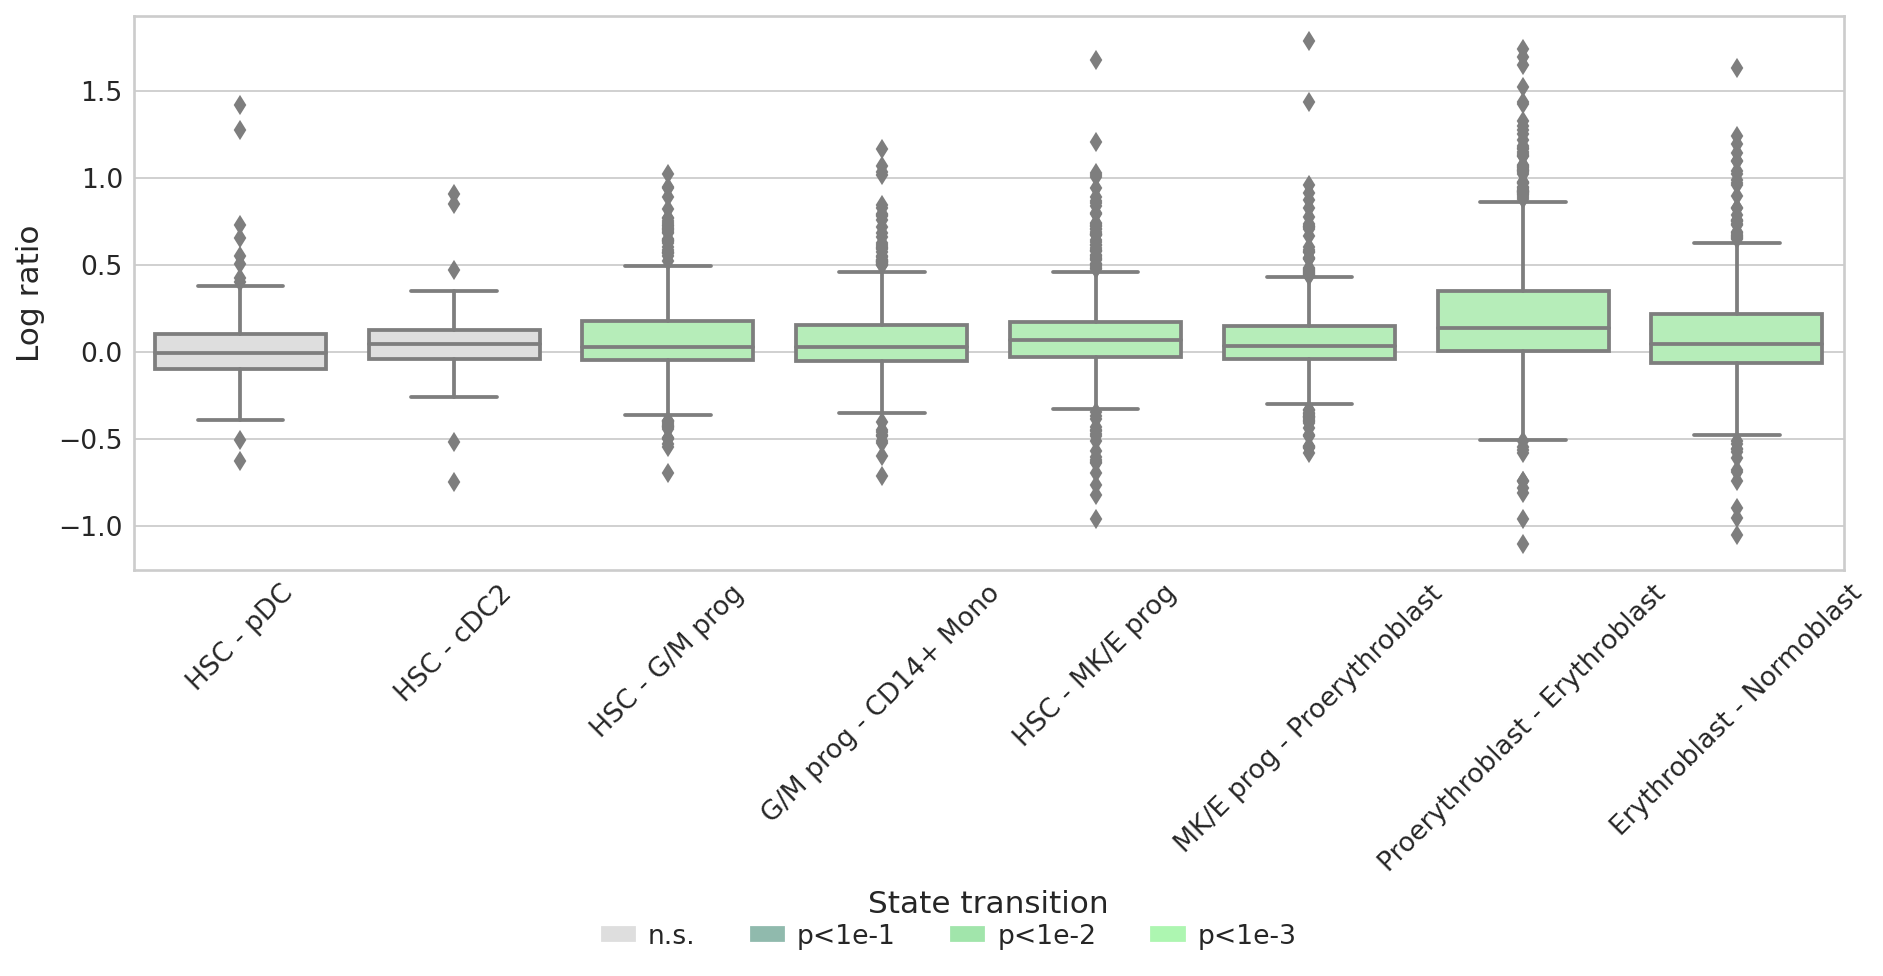

In [16]:
dfs = []

ttest_res = {}
significances = {}

for source, target in STATE_TRANSITIONS:
    obs_mask = score_df["State transition"].isin([f"{source} - {target}"])
    a = score_df.loc[obs_mask, "Log ratio"].values
    b = np.zeros(len(a))

    ttest_res[f"{source} - {target}"] = ttest_ind(a, b, equal_var=False, alternative="greater")
    significances[f"{source} - {target}"] = get_significance(ttest_res[f"{source} - {target}"].pvalue)

significance_palette = {"n.s.": "#dedede", "*": "#90BAAD", "**": "#A1E5AB", "***": "#ADF6B1"}

palette = {
    state_transition: significance_palette[significance] for state_transition, significance in significances.items()
}

if running_in_notebook():
    with mplscience.style_context():
        sns.set_style(style="whitegrid")
        fig, ax = plt.subplots(figsize=(12, 6))

        sns.boxplot(data=score_df, x="State transition", y="Log ratio", palette=palette, ax=ax)

        ax.tick_params(axis="x", rotation=45)

        handles = [Patch(label=label, facecolor=color) for label, color in significance_palette.items()]
        fig.legend(
            handles=handles,
            labels=["n.s.", "p<1e-1", "p<1e-2", "p<1e-3"],
            loc="lower center",
            ncol=4,
            bbox_to_anchor=(0.5, -0.025),
        )
        fig.tight_layout()
        plt.show()

        if SAVE_FIGURES:
            ax.set(xlabel="", xticklabels="", ylabel="", yticklabels="")
            fig.legends = []

            fig.savefig(
                FIG_DIR / "pseudotime_kernel" / "hematopoiesis" / f"log_ratio_cross_boundary.{FIGURE_FORMAT}",
                format=FIGURE_FORMAT,
                transparent=True,
                bbox_inches="tight",
            )